## 1. Candy Crush Saga
<p><a href="https://king.com/game/candycrush">Candy Crush Saga</a> is a hit mobile game developed by King (part of Activision|Blizzard) that is played by millions of people all around the world. The game is structured as a series of levels where players need to match similar candy together to (hopefully) clear the level and keep progressing on the level map. If you are one of the few that haven't played Candy Crush, here's a short demo:</p>
<p><a href="https://youtu.be/HGLGxnfs_t8"><img src="https://assets.datacamp.com/production/project_139/img/candy_crush_video.jpeg" alt=""></a></p>
<p>Candy Crush has more than 3000 levels, and new ones are added every week. That is a lot of levels! And with that many levels, it's important to get <em>level difficulty</em> just right. Too easy and the game gets boring, too hard and players become frustrated and quit playing.</p>
<p>In this project, we will see how we can use data collected from players to estimate level difficulty. Let's start by loading in the packages we're going to need.</p>

In [3]:
# This sets the size of plots to a good default.
options(repr.plot.width = 5, repr.plot.height = 4)

# Loading in packages
library(tidyverse)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v tibble  2.0.1     v purrr   0.3.1
v tidyr   0.8.3     v stringr 1.2.0
v tibble  2.0.1     v forcats 0.4.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


## 2. The data set
<p>The dataset we will use contains one week of data from a sample of players who played Candy Crush back in 2014. The data is also from a single <em>episode</em>, that is, a set of 15 levels. It has the following columns:</p>
<ul>
<li><strong>player_id</strong>: a unique player id</li>
<li><strong>dt</strong>: the date</li>
<li><strong>level</strong>: the level number within the episode, from 1 to 15.</li>
<li><strong>num_attempts</strong>: number of level attempts for the player on that level and date.</li>
<li><strong>num_success</strong>: number of level attempts that resulted in a success/win for the player on that level and date.</li>
</ul>
<p>The granularity of the dataset is player, date, and level. That is, there is a row for every player, day, and level recording the total number of attempts and how many of those resulted in a win.</p>
<p>Now, let's load in the dataset and take a look at the first couple of rows. </p>

In [2]:
# Reading in the data
data <- read_csv("datasets/candy_crush.csv")

# Printing out the first couple of rows
head(data)

Parsed with column specification:
cols(
  player_id = col_character(),
  dt = col_date(format = ""),
  level = col_double(),
  num_attempts = col_double(),
  num_success = col_double()
)


player_id,dt,level,num_attempts,num_success
6dd5af4c7228fa353d505767143f5815,2014-01-04,4,3,1
c7ec97c39349ab7e4d39b4f74062ec13,2014-01-01,8,4,1
c7ec97c39349ab7e4d39b4f74062ec13,2014-01-05,12,6,0
a32c5e9700ed356dc8dd5bb3230c5227,2014-01-03,11,1,1
a32c5e9700ed356dc8dd5bb3230c5227,2014-01-07,15,6,0
b94d403ac4edf639442f93eeffdc7d92,2014-01-01,8,8,1


## 3. Checking the data set
<p>Now that we have loaded the dataset let's count how many players we have in the sample and how many days worth of data we have.</p>

In [4]:
print("Number of players:")
length(unique(data$player_id))

print("Period for which we have data:")
range(data$dt)

[1] "Number of players:"


[1] 6814

[1] "Period for which we have data:"


[1] "2014-01-01" "2014-01-07"

## 4. Computing level difficulty
<p>Within each Candy Crush episode, there is a mix of easier and tougher levels. Luck and individual skill make the number of attempts required to pass a level different from player to player. The assumption is that difficult levels require more attempts on average than easier ones. That is, <em>the harder</em> a level is, <em>the lower</em> the probability to pass that level in a single attempt is.</p>
<p>A simple approach to model this probability is as a <a href="https://en.wikipedia.org/wiki/Bernoulli_process">Bernoulli process</a>; as a binary outcome (you either win or lose) characterized by a single parameter <em>p<sub>win</sub></em>: the probability of winning the level in a single attempt. This probability can be estimated for each level as:</p>
<p><img src="https://assets.datacamp.com/production/project_139/img/latex1.png" style="width:150px"></p>
<!-- $$p_{win} = \frac{\sum wins}{\sum attempts}$$ -->
<p>For example, let's say a level has been played 10 times and 2 of those attempts ended up in a victory. Then the probability of winning in a single attempt would be <em>p<sub>win</sub></em> = 2 / 10 = 20%.</p>
<p>Now, let's compute the difficulty <em>p<sub>win</sub></em> separately for each of the 15 levels.</p>

In [9]:
# Calculating level difficulty
difficulty <- data%>%
  group_by(level)%>%
  summarise(attempts = sum(num_attempts), wins = sum(num_success))%>%
  mutate(p_win = wins/attempts)

# Printing out the level difficulty
print(difficulty)

# A tibble: 15 x 4
   level attempts  wins  p_win
   <dbl>    <dbl> <dbl>  <dbl>
 1     1     1322   818 0.619 
 2     2     1285   666 0.518 
 3     3     1546   662 0.428 
 4     4     1893   705 0.372 
 5     5     6937   634 0.0914
 6     6     1591   668 0.420 
 7     7     4526   614 0.136 
 8     8    15816   641 0.0405
 9     9     8241   670 0.0813
10    10     3282   617 0.188 
11    11     5575   603 0.108 
12    12     6868   659 0.0960
13    13     1327   686 0.517 
14    14     2772   777 0.280 
15    15    30374  1157 0.0381


## 5. Plotting difficulty profile
<p><img src="https://assets.datacamp.com/production/project_139/img/tiffi.jpeg" style="height:150px; float:left"> </p>
<p>Great! We now have the difficulty for all the 15 levels in the episode. Keep in mind that, as we measure difficulty as the probability to pass a level in a single attempt, a <em>lower</em> value (a smaller probability of winning the level) implies a <em>higher</em> level difficulty.</p>
<p>Now that we have the difficulty of the episode we should plot it. Let's plot a line graph with the levels on the X-axis and the difficulty (<em>p<sub>win</sub></em>) on the Y-axis. We call this plot the <em>difficulty profile</em> of the episode.</p>

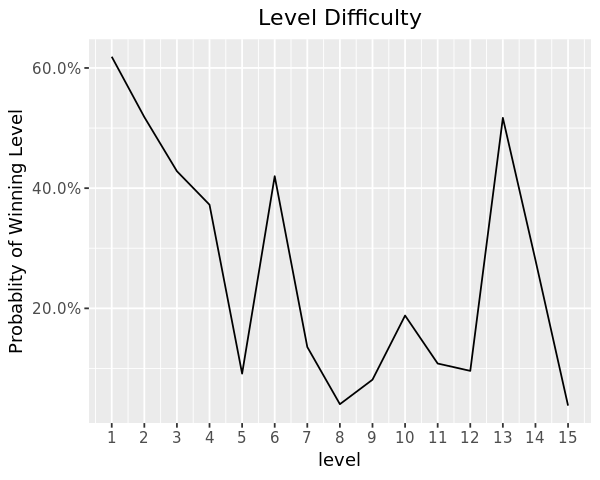

In [14]:
# Plotting the level difficulty profile
ggplot(data = difficulty, aes(x = level, y = p_win))+
geom_line()+
scale_x_continuous(breaks = 1:15)+
scale_y_continuous(label = scales::percent)+
ylab("Probablity of Winning Level")+
ggtitle("Level Difficulty")+
theme(plot.title = element_text(hjust = 0.5))

## 6. Spotting hard levels
<p>What constitutes a <em>hard</em> level is subjective. However, to keep things simple, we could define a threshold of difficulty, say 10%, and label levels with <em>p<sub>win</sub></em> &lt; 10% as <em>hard</em>. It's relatively easy to spot these hard levels on the plot, but we can make the plot more friendly by explicitly highlighting the hard levels.</p>

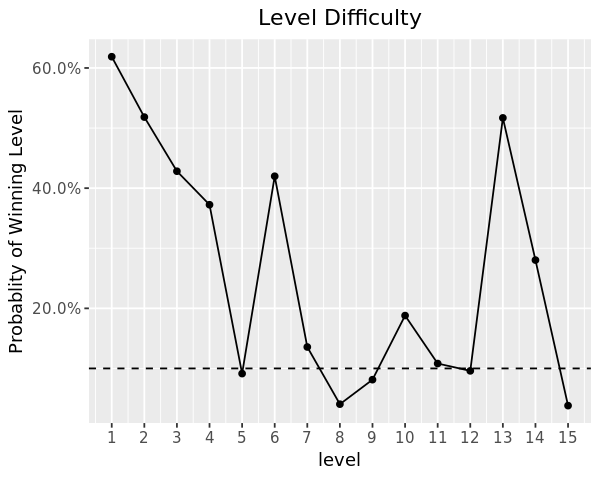

In [16]:
# Adding points and a dashed line
ggplot(data = difficulty, aes(x = level, y = p_win))+
geom_line()+
scale_x_continuous(breaks = 1:15)+
scale_y_continuous(label = scales::percent)+
ylab("Probablity of Winning Level")+
ggtitle("Level Difficulty")+
theme(plot.title = element_text(hjust = 0.5))+
geom_point()+
geom_hline(yintercept = 0.1, linetype = 'dashed')

## 7. Computing uncertainty
<p><img src="https://assets.datacamp.com/production/project_139/img/mr_toffee.jpeg" style="height:350px; float:right"> </p>
<p>As Data Scientists we should always report some measure of the uncertainty of any provided numbers. Maybe tomorrow, another sample will give us slightly different values for the difficulties? Here we will simply use the <a href="https://en.wikipedia.org/wiki/Standard_error"><em>Standard error</em></a> as a measure of uncertainty:</p>
<p><img src="https://assets.datacamp.com/production/project_139/img/latex2.png" style="width:115px"></p>
<!-- $$
\sigma_{error} \approx \frac{\sigma_{sample}}{\sqrt{n}}
$$ -->
<p>Here <em>n</em> is the number of datapoints and <em>σ<sub>sample</sub></em> is the sample standard deviation. For a Bernoulli process, the sample standard deviation is: </p>
<p><img src="https://assets.datacamp.com/production/project_139/img/latex3.png" style="width:195px"></p>
<!-- $$
\sigma_{sample} = \sqrt{p_{win} (1 - p_{win})} 
$$ -->
<p>Therefore, we can calculate the standard error like this:</p>
<p><img src="https://assets.datacamp.com/production/project_139/img/latex4.png" style="width:195px"></p>
<!-- $$
\sigma_{error} \approx \sqrt{\frac{p_{win}(1 - p_{win})}{n}}
$$ -->
<p>We already have all we need in the <code>difficulty</code> data frame! Every level has been played <em>n</em> number of times and we have their difficulty <em>p<sub>win</sub></em>. Now, let's calculate the standard error for each level.</p>

In [19]:
# Computing the standard error of p_win for each level
difficulty <- difficulty %>%
    mutate(error = sqrt(p_win * (1-p_win)/attempts))
difficulty

level,attempts,wins,p_win,error
1,1322,818,0.61875946,0.013358101
2,1285,666,0.51828794,0.013938876
3,1546,662,0.42820181,0.012584643
4,1893,705,0.37242472,0.011111607
5,6937,634,0.09139397,0.003459878
6,1591,668,0.41986172,0.012373251
7,4526,614,0.13566063,0.005089930
8,15816,641,0.04052858,0.001568008
9,8241,670,0.08130081,0.003010538
10,3282,617,0.18799512,0.006819983


## 8. Showing uncertainty
<p>Now that we have a measure of uncertainty for each levels' difficulty estimate let's use <em>error bars</em> to show this uncertainty in the plot. We will set the length of the error bars to one standard error. The upper limit and the lower limit of each error bar should then be <em>p<sub>win</sub></em> + <em>σ<sub>error</sub></em> and <em>p<sub>win</sub></em> - <em>σ<sub>error</sub></em>, respectively.</p>

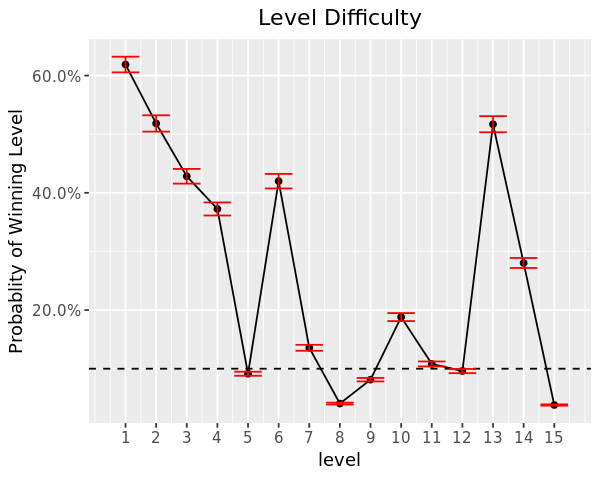

In [23]:
# Adding standard error bars
ggplot(data = difficulty, aes(x = level, y = p_win))+
geom_line()+
scale_x_continuous(breaks = 1:15)+
scale_y_continuous(label = scales::percent)+
ylab("Probablity of Winning Level")+
ggtitle("Level Difficulty")+
theme(plot.title = element_text(hjust = 0.5))+
geom_point()+
geom_hline(yintercept = 0.1, linetype = 'dashed')+
geom_errorbar(aes(ymin = p_win-error, ymax = p_win+error), color = 'red')

## 9. A final metric
<p>It looks like our difficulty estimates are pretty precise! Using this plot, a level designer can quickly spot where the hard levels are and also see if there seems to be too many hard levels in the episode.</p>
<p>One question a level designer might ask is: "How likely is it that a player will complete the episode without losing a single time?" Let's calculate this using the estimated level difficulties!</p>

In [24]:
# The probability of completing the episode without losing a single time
p <- prod(difficulty$p_win)

# Printing it out
p

[1] 9.447141e-12

## 10. Should our level designer worry?
<p>Given the probability we just calculated, should our level designer worry about that a lot of players might complete the episode in one attempt?</p>

In [0]:
# Should our level designer worry about that a lot of 
# players will complete the episode in one attempt?
should_the_designer_worry = .... # TRUE / FALSE